In [20]:


image = Image.open ("screenshot.jpg")
image.show
width, height = image.size

In [19]:
from __future__ import division
from __future__ import print_function
import collections
import math
import matplotlib.pyplot as plt


Point = collections.namedtuple("Point", ["x", "y"])



#Core Definitions 
_Hex = collections.namedtuple("Hex", ["q", "r", "s"])
def Hex(q, r, s):
    assert not (round(q + r + s) != 0), "q + r + s must be 0"
    return _Hex(q, r, s)

#basic Hex Opertations     

def hex_add(a, b):
    return Hex(a.q + b.q, a.r + b.r, a.s + b.s)

def hex_subtract(a, b):
    return Hex(a.q - b.q, a.r - b.r, a.s - b.s)

def hex_scale(a, k):
    return Hex(a.q * k, a.r * k, a.s * k)

def hex_rotate_left(a):
    return Hex(-a.s, -a.q, -a.r)

def hex_rotate_right(a):
    return Hex(-a.r, -a.s, -a.q)

#Neighboring and Distance    

hex_directions = [Hex(1, 0, -1), Hex(1, -1, 0), Hex(0, -1, 1), Hex(-1, 0, 1), Hex(-1, 1, 0), Hex(0, 1, -1)]
def hex_direction(direction):
    return hex_directions[direction]

def hex_neighbor(hex, direction):
    return hex_add(hex, hex_direction(direction))

hex_diagonals = [Hex(2, -1, -1), Hex(1, -2, 1), Hex(-1, -1, 2), Hex(-2, 1, 1), Hex(-1, 2, -1), Hex(1, 1, -2)]
def hex_diagonal_neighbor(hex, direction):
    return hex_add(hex, hex_diagonals[direction])

def hex_length(hex):
    return (abs(hex.q) + abs(hex.r) + abs(hex.s)) // 2

def hex_distance(a, b):
    return hex_length(hex_subtract(a, b))

def hex_round(h):
    qi = int(round(h.q))
    ri = int(round(h.r))
    si = int(round(h.s))
    q_diff = abs(qi - h.q)
    r_diff = abs(ri - h.r)
    s_diff = abs(si - h.s)
    if q_diff > r_diff and q_diff > s_diff:
        qi = -ri - si
    else:
        if r_diff > s_diff:
            ri = -qi - si
        else:
            si = -qi - ri
    return Hex(qi, ri, si)

def hex_lerp(a, b, t):
    return Hex(a.q * (1.0 - t) + b.q * t, a.r * (1.0 - t) + b.r * t, a.s * (1.0 - t) + b.s * t)


def hex_linedraw(a, b):
    N = hex_distance(a, b)
    a_nudge = Hex(a.q + 1e-06, a.r + 1e-06, a.s - 2e-06)
    b_nudge = Hex(b.q + 1e-06, b.r + 1e-06, b.s - 2e-06)
    results = []
    step = 1.0 / max(N, 1)
    for i in range(0, N + 1):
        results.append(hex_round(hex_lerp(a_nudge, b_nudge, step * i)))
    return results




OffsetCoord = collections.namedtuple("OffsetCoord", ["col", "row"])

EVEN = 1
ODD = -1
def qoffset_from_cube(offset, h):
    col = h.q
    row = h.r + (h.q + offset * (h.q & 1)) // 2
    if offset != EVEN and offset != ODD:
        raise ValueError("offset must be EVEN (+1) or ODD (-1)")
    return OffsetCoord(col, row)


#Conversions Between Coordinate Systems    

def qoffset_to_cube(offset, h):
    q = h.col
    r = h.row - (h.col + offset * (h.col & 1)) // 2
    s = -q - r
    if offset != EVEN and offset != ODD:
        raise ValueError("offset must be EVEN (+1) or ODD (-1)")
    return Hex(q, r, s)

def roffset_from_cube(offset, h):
    col = h.q + (h.r + offset * (h.r & 1)) // 2
    row = h.r
    if offset != EVEN and offset != ODD:
        raise ValueError("offset must be EVEN (+1) or ODD (-1)")
    return OffsetCoord(col, row)

def roffset_to_cube(offset, h):
    q = h.col - (h.row + offset * (h.row & 1)) // 2
    r = h.row
    s = -q - r
    if offset != EVEN and offset != ODD:
        raise ValueError("offset must be EVEN (+1) or ODD (-1)")
    return Hex(q, r, s)




DoubledCoord = collections.namedtuple("DoubledCoord", ["col", "row"])

def qdoubled_from_cube(h):
    col = h.q
    row = 2 * h.r + h.q
    return DoubledCoord(col, row)

def qdoubled_to_cube(h):
    q = h.col
    r = (h.row - h.col) // 2
    s = -q - r
    return Hex(q, r, s)

def rdoubled_from_cube(h):
    col = 2 * h.q + h.r
    row = h.r
    return DoubledCoord(col, row)

def rdoubled_to_cube(h):
    q = (h.col - h.row) // 2
    r = h.row
    s = -q - r
    return Hex(q, r, s)




Orientation = collections.namedtuple("Orientation", ["f0", "f1", "f2", "f3", "b0", "b1", "b2", "b3", "start_angle"])




Layout = collections.namedtuple("Layout", ["orientation", "size", "origin"])

layout_pointy = Orientation(math.sqrt(3.0), math.sqrt(3.0) / 2.0, 0.0, 3.0 / 2.0, math.sqrt(3.0) / 3.0, -1.0 / 3.0, 0.0, 2.0 / 3.0, 0.5)
layout_flat = Orientation(3.0 / 2.0, 0.0, math.sqrt(3.0) / 2.0, math.sqrt(3.0), 2.0 / 3.0, 0.0, -1.0 / 3.0, math.sqrt(3.0) / 3.0, 0.0)
def hex_to_pixel(layout, h):
    M = layout.orientation
    size = layout.size
    origin = layout.origin
    x = (M.f0 * h.q + M.f1 * h.r) * size.x
    y = (M.f2 * h.q + M.f3 * h.r) * size.y
    return Point(x + origin.x, y + origin.y)

#Pixel Conversion 

def pixel_to_hex(layout, p):
    M = layout.orientation
    size = layout.size
    origin = layout.origin
    pt = Point((p.x - origin.x) / size.x, (p.y - origin.y) / size.y)
    q = M.b0 * pt.x + M.b1 * pt.y
    r = M.b2 * pt.x + M.b3 * pt.y
    return Hex(q, r, -q - r)


#Rendering Hexes 
def hex_corner_offset(layout, corner):
    M = layout.orientation
    size = layout.size
    angle = 2.0 * math.pi * (M.start_angle - corner) / 6.0
    return Point(size.x * math.cos(angle), size.y * math.sin(angle))

def polygon_corners(layout, h):
    corners = []
    center = hex_to_pixel(layout, h)
    for i in range(0, 6):
        offset = hex_corner_offset(layout, i)
        corners.append(Point(center.x + offset.x, center.y + offset.y))
    return corners




# Testing

def complain(name):
    print("FAIL {0}".format(name))

def equal_hex(name, a, b):
    if not (a.q == b.q and a.s == b.s and a.r == b.r):
        complain(name)

def equal_offsetcoord(name, a, b):
    if not (a.col == b.col and a.row == b.row):
        complain(name)

def equal_doubledcoord(name, a, b):
    if not (a.col == b.col and a.row == b.row):
        complain(name)

def equal_int(name, a, b):
    if not (a == b):
        complain(name)

def equal_hex_array(name, a, b):
    equal_int(name, len(a), len(b))
    for i in range(0, len(a)):
        equal_hex(name, a[i], b[i])

def test_hex_arithmetic():
    equal_hex("hex_add", Hex(4, -10, 6), hex_add(Hex(1, -3, 2), Hex(3, -7, 4)))
    equal_hex("hex_subtract", Hex(-2, 4, -2), hex_subtract(Hex(1, -3, 2), Hex(3, -7, 4)))

def test_hex_direction():
    equal_hex("hex_direction", Hex(0, -1, 1), hex_direction(2))

def test_hex_neighbor():
    equal_hex("hex_neighbor", Hex(1, -3, 2), hex_neighbor(Hex(1, -2, 1), 2))

def test_hex_diagonal():
    equal_hex("hex_diagonal", Hex(-1, -1, 2), hex_diagonal_neighbor(Hex(1, -2, 1), 3))

def test_hex_distance():
    equal_int("hex_distance", 7, hex_distance(Hex(3, -7, 4), Hex(0, 0, 0)))

def test_hex_rotate_right():
    equal_hex("hex_rotate_right", hex_rotate_right(Hex(1, -3, 2)), Hex(3, -2, -1))

def test_hex_rotate_left():
    equal_hex("hex_rotate_left", hex_rotate_left(Hex(1, -3, 2)), Hex(-2, -1, 3))

def test_hex_round():
    a = Hex(0.0, 0.0, 0.0)
    b = Hex(1.0, -1.0, 0.0)
    c = Hex(0.0, -1.0, 1.0)
    equal_hex("hex_round 1", Hex(5, -10, 5), hex_round(hex_lerp(Hex(0.0, 0.0, 0.0), Hex(10.0, -20.0, 10.0), 0.5)))
    equal_hex("hex_round 2", hex_round(a), hex_round(hex_lerp(a, b, 0.499)))
    equal_hex("hex_round 3", hex_round(b), hex_round(hex_lerp(a, b, 0.501)))
    equal_hex("hex_round 4", hex_round(a), hex_round(Hex(a.q * 0.4 + b.q * 0.3 + c.q * 0.3, a.r * 0.4 + b.r * 0.3 + c.r * 0.3, a.s * 0.4 + b.s * 0.3 + c.s * 0.3)))
    equal_hex("hex_round 5", hex_round(c), hex_round(Hex(a.q * 0.3 + b.q * 0.3 + c.q * 0.4, a.r * 0.3 + b.r * 0.3 + c.r * 0.4, a.s * 0.3 + b.s * 0.3 + c.s * 0.4)))

def test_hex_linedraw():
    equal_hex_array("hex_linedraw", [Hex(0, 0, 0), Hex(0, -1, 1), Hex(0, -2, 2), Hex(1, -3, 2), Hex(1, -4, 3), Hex(1, -5, 4)], hex_linedraw(Hex(0, 0, 0), Hex(1, -5, 4)))

def test_layout():
    h = Hex(3, 4, -7)
    flat = Layout(layout_flat, Point(10.0, 15.0), Point(35.0, 71.0))
    equal_hex("layout", h, hex_round(pixel_to_hex(flat, hex_to_pixel(flat, h))))
    pointy = Layout(layout_pointy, Point(10.0, 15.0), Point(35.0, 71.0))
    equal_hex("layout", h, hex_round(pixel_to_hex(pointy, hex_to_pixel(pointy, h))))

def test_offset_roundtrip():
    a = Hex(3, 4, -7)
    b = OffsetCoord(1, -3)
    equal_hex("conversion_roundtrip even-q", a, qoffset_to_cube(EVEN, qoffset_from_cube(EVEN, a)))
    equal_offsetcoord("conversion_roundtrip even-q", b, qoffset_from_cube(EVEN, qoffset_to_cube(EVEN, b)))
    equal_hex("conversion_roundtrip odd-q", a, qoffset_to_cube(ODD, qoffset_from_cube(ODD, a)))
    equal_offsetcoord("conversion_roundtrip odd-q", b, qoffset_from_cube(ODD, qoffset_to_cube(ODD, b)))
    equal_hex("conversion_roundtrip even-r", a, roffset_to_cube(EVEN, roffset_from_cube(EVEN, a)))
    equal_offsetcoord("conversion_roundtrip even-r", b, roffset_from_cube(EVEN, roffset_to_cube(EVEN, b)))
    equal_hex("conversion_roundtrip odd-r", a, roffset_to_cube(ODD, roffset_from_cube(ODD, a)))
    equal_offsetcoord("conversion_roundtrip odd-r", b, roffset_from_cube(ODD, roffset_to_cube(ODD, b)))

def test_offset_from_cube():
    equal_offsetcoord("offset_from_cube even-q", OffsetCoord(1, 3), qoffset_from_cube(EVEN, Hex(1, 2, -3)))
    equal_offsetcoord("offset_from_cube odd-q", OffsetCoord(1, 2), qoffset_from_cube(ODD, Hex(1, 2, -3)))

def test_offset_to_cube():
    equal_hex("offset_to_cube even-", Hex(1, 2, -3), qoffset_to_cube(EVEN, OffsetCoord(1, 3)))
    equal_hex("offset_to_cube odd-q", Hex(1, 2, -3), qoffset_to_cube(ODD, OffsetCoord(1, 2)))

def test_doubled_roundtrip():
    a = Hex(3, 4, -7)
    b = DoubledCoord(1, -3)
    equal_hex("conversion_roundtrip doubled-q", a, qdoubled_to_cube(qdoubled_from_cube(a)))
    equal_doubledcoord("conversion_roundtrip doubled-q", b, qdoubled_from_cube(qdoubled_to_cube(b)))
    equal_hex("conversion_roundtrip doubled-r", a, rdoubled_to_cube(rdoubled_from_cube(a)))
    equal_doubledcoord("conversion_roundtrip doubled-r", b, rdoubled_from_cube(rdoubled_to_cube(b)))

def test_doubled_from_cube():
    equal_doubledcoord("doubled_from_cube doubled-q", DoubledCoord(1, 5), qdoubled_from_cube(Hex(1, 2, -3)))
    equal_doubledcoord("doubled_from_cube doubled-r", DoubledCoord(4, 2), rdoubled_from_cube(Hex(1, 2, -3)))

def test_doubled_to_cube():
    equal_hex("doubled_to_cube doubled-q", Hex(1, 2, -3), qdoubled_to_cube(DoubledCoord(1, 5)))
    equal_hex("doubled_to_cube doubled-r", Hex(1, 2, -3), rdoubled_to_cube(DoubledCoord(4, 2)))

def test_all():
    test_hex_arithmetic()
    test_hex_direction()
    test_hex_neighbor()
    test_hex_diagonal()
    test_hex_distance()
    test_hex_rotate_right()
    test_hex_rotate_left()
    test_hex_round()
    test_hex_linedraw()
    test_layout()
    test_offset_roundtrip()
    test_offset_from_cube()
    test_offset_to_cube()
    test_doubled_roundtrip()
    test_doubled_from_cube()
    test_doubled_to_cube()



if __name__ == '__main__': test_all()


In [21]:
layout = Layout(layout_flat, Point(13, 13), Point(0, 0))  # Adjust hex size as needed


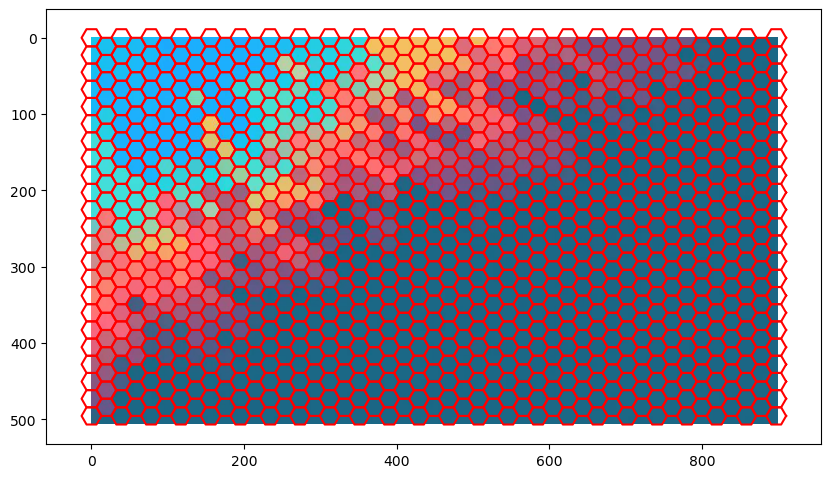

In [76]:
width, height = image.size
cols = width // 10  # Column size- adjusted  based on hex dimensions
rows = height // 10

hexes = []
for col in range(-cols, cols):
    for row in range(-rows, rows):
        hex = Hex(col, row, -col - row)
        center = hex_to_pixel(layout, hex)
        if 0 <= center.x < width and 0 <= center.y < height:
            hexes.append((hex, polygon_corners(layout, hex)))

# Plot the hexagons over the image
plt.figure(figsize=(10, 10))
plt.imshow(image)
hex_list=[]
for hex, corners in hexes:
    hex_list.append(hex)
    x_vals = [corner.x for corner in corners] + [corners[0].x]
    y_vals = [corner.y for corner in corners] + [corners[0].y]
    plt.plot(x_vals, y_vals, color="red")  # Hex grid lines in red
plt.show()


In [23]:
def convert_hex_to_pixels(layout, hex_list):
    xy_pixel_list = []
    for i in hex_list:
        xy_pixel_list.append(hex_to_pixel(layout, i))  
    return xy_pixel_list  



In [24]:
xy_pixel_list = convert_hex_to_pixels(layout, hex_list)
xy_pixel_list[1]
len(xy_pixel_list)

1058

In [25]:
xy_values = [(point.x, point.y) for point in xy_pixel_list]
print(xy_values) 


[(0.0, 0.0), (0.0, 22.516660498395403), (0.0, 45.033320996790806), (0.0, 67.54998149518622), (0.0, 90.06664199358161), (0.0, 112.58330249197701), (0.0, 135.09996299037243), (0.0, 157.61662348876783), (0.0, 180.13328398716322), (0.0, 202.64994448555862), (0.0, 225.16660498395402), (0.0, 247.68326548234944), (0.0, 270.19992598074487), (0.0, 292.71658647914023), (0.0, 315.23324697753566), (0.0, 337.749907475931), (0.0, 360.26656797432645), (0.0, 382.7832284727219), (0.0, 405.29988897111724), (0.0, 427.81654946951267), (0.0, 450.33320996790803), (0.0, 472.8498704663035), (0.0, 495.3665309646989), (19.5, 11.258330249197702), (19.5, 33.77499074759311), (19.5, 56.291651245988504), (19.5, 78.80831174438391), (19.5, 101.32497224277931), (19.5, 123.84163274117472), (19.5, 146.35829323957014), (19.5, 168.87495373796554), (19.5, 191.39161423636094), (19.5, 213.90827473475633), (19.5, 236.4249352331517), (19.5, 258.9415957315471), (19.5, 281.45825622994255), (19.5, 303.9749167283379), (19.5, 326.49

In [58]:

print (image.getpixel(xy_values[0]))
pixel=[]

def pixel_function ():
    for i in xy_values :
        pixel.append(image.getpixel(i))
    return pixel   

pixel= pixel_function ()
len(pixel)
pixel



(22, 199, 232)


[(22, 199, 232),
 (25, 193, 240),
 (25, 190, 244),
 (28, 188, 250),
 (24, 184, 246),
 (43, 205, 226),
 (66, 222, 221),
 (66, 222, 221),
 (67, 221, 221),
 (67, 221, 221),
 (71, 219, 223),
 (98, 203, 199),
 (201, 146, 143),
 (205, 141, 141),
 (231, 137, 125),
 (250, 130, 114),
 (254, 115, 118),
 (245, 105, 118),
 (222, 100, 123),
 (170, 96, 129),
 (135, 87, 129),
 (119, 85, 136),
 (37, 104, 131),
 (25, 193, 240),
 (26, 190, 243),
 (28, 175, 252),
 (27, 180, 250),
 (36, 204, 230),
 (38, 208, 231),
 (70, 222, 210),
 (67, 221, 223),
 (67, 221, 219),
 (67, 222, 214),
 (246, 120, 134),
 (236, 130, 132),
 (232, 129, 130),
 (228, 140, 130),
 (252, 131, 112),
 (254, 122, 118),
 (252, 106, 129),
 (203, 101, 122),
 (162, 103, 123),
 (147, 90, 131),
 (145, 83, 134),
 (102, 88, 137),
 (24, 191, 243),
 (26, 190, 243),
 (26, 190, 243),
 (28, 175, 253),
 (27, 180, 250),
 (28, 175, 253),
 (26, 176, 253),
 (28, 178, 254),
 (66, 222, 219),
 (67, 222, 216),
 (67, 221, 219),
 (67, 224, 213),
 (183, 186, 155

In [27]:
from IPython.core.display import display ,  HTML


C:\Users\zoro\AppData\Local\Temp\ipykernel_34052\2015337903.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display ,  HTML


In [83]:
# Function to generate SVG hexagons
def generate_svg_from_hexes(hexes, image_width, image_height, pixel_colors):
    hexagons = ""
    for idx, (hex, corners) in enumerate(hexes):
        # Getting the corners as SVG-compatible "x,y x,y ..." format
        points = " ".join(f"{corner.x},{corner.y}" for corner in corners)
        
        # Assigning color from pixel_colors (ensure index is in bounds)
        if idx < len(pixel_colors):
            r, g, b = pixel_colors[idx]
            color = f"rgb({r},{g},{b})"
        else:
            color = "rgb(200, 200, 200)"  # Default gray color
        
        # Adding a hexagon as an SVG <polygon>
        hexagons += f"""
        <polygon points="{points}" 
                 stroke="red" 
                 fill="{color}" 
                 stroke-width="1" />
        """

    # Combining all hexagons into an SVG structure
    svg_code = f"""
    <svg xmlns="http://www.w3.org/2000/svg" 
         width="{image_width}" height="{image_height}">
        {hexagons}
    </svg>
    """
    return svg_code


# Generating the SVG from hexes
width, height = image.size  # Using the same image dimensions
svg_code = generate_svg_from_hexes(hexes, width, height, pixel)

# Displaying SVG in the notebook
from IPython.display import display, HTML
display(HTML(svg_code))


# Save the SVG to a file
with open('output.svg', 'w') as f:
    f.write(svg_code)

print("SVG file 'output.svg' has been saved!")


SVG file 'output.svg' has been saved!


In [80]:
# Generate the SVG content
width, height = image.size  # Use the image dimensions
svg_content = generate_svg_from_hexes(hexes, width, height, pixel)

# Save the SVG to a file
with open('outputy.svg', 'w') as f:
    f.write(svg_content)

print("SVG file 'output.svg' has been saved!")

SVG file 'output.svg' has been saved!
